<a href="https://colab.research.google.com/github/t-whiteley/ML/blob/main/03PytorchConvolutionalNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([1, 28, 28]) 60000 60000 10000 10000


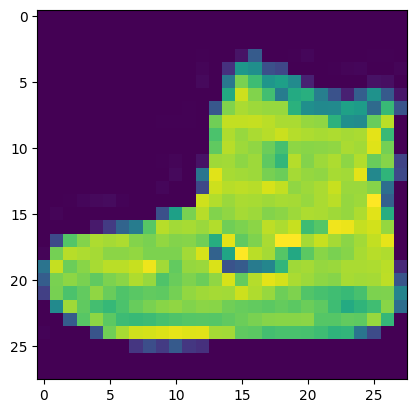

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else 'cpu'

train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
image, label = train_data[0]
class_names = train_data.classes
print(image.shape, len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets))
plt.imshow(image.squeeze())

torch.Size([32, 1, 28, 28]) torch.Size([32]) torch.Size([1, 28, 28])


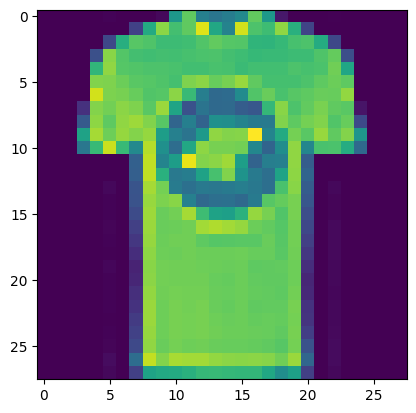

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_CLASSES = len(class_names)

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

train_batch_features, train_batch_labels = next(iter(train_dataloader))
print(train_batch_features.shape, train_batch_labels.shape, train_batch_features[0].shape)
plt.imshow(train_batch_features[0].squeeze())

In [ ]:
class FashionMNISTv2(nn.Module):
  def __init__(self, num_features, num_classes, hidden_layer):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(num_features, hidden_layer, kernel_size = 3, stride = 1, padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_layer, hidden_layer, kernel_size = 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(hidden_layer, hidden_layer, kernel_size = 3, stride = 1, padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_layer, hidden_layer, kernel_size = 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.clasifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_layer*5*5, out_features = num_classes)
    )

  def forward(self, x):
    # print(x.shape)
    x = self.block1(x)
    # print(x.shape)
    x = self.block2(x)
    # print(x.shape)
    x = self.clasifier(x)
    # print(x.shape)
    return x

torch.manual_seed(42)
model = FashionMNISTv2(1, 10, NUM_CLASSES)
model

FashionMNISTv2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

In [ ]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, device: torch.device):
    train_loss = 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")

def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    test_loss = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)

        test_loss /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}")


In [ ]:
epochs = 3
for epoch in range(epochs):
  print("epoch: ", epoch)
  train_step(model, train_dataloader, loss_fn, optimizer, device)
  test_step(test_dataloader, model, loss_fn, device)

epoch:  0
Train loss: 0.67297
Test loss: 0.43948
epoch:  1
Train loss: 0.40086
Test loss: 0.41336
epoch:  2
Train loss: 0.36642
Test loss: 0.36933


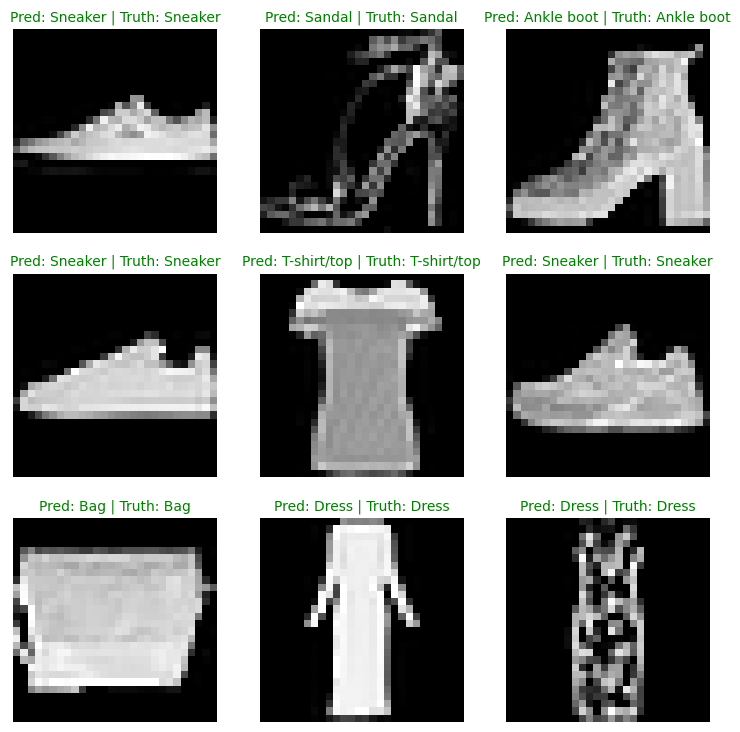

In [ ]:
import random
random.seed(14)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

pred_probs= make_predictions(model=model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
test_labels, pred_classes

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);